```
         Copyright Rein Halbersma 2020-2021.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 5 Monte Carlo Methods

## 5.1 Monte Carlo Prediction

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc
from doctrina.spaces import shape, size
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1')
env.seed(47110815)

[47110815]

**Example 5.1: Blackjack**

In [2]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(env.observation_shape, bj.Action.HIT)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.STAND
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.STAND
stand_on_20 = stand_on_20.reshape(env.nS)

In [3]:
# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, Ns = zip(*[ 
    mc.V_predict_ev(env, stand_on_20, episodes, format='deter') 
    for episodes in runs 
])

100%|██████████| 500000/500000 [00:08<00:00, 57125.76it/s]


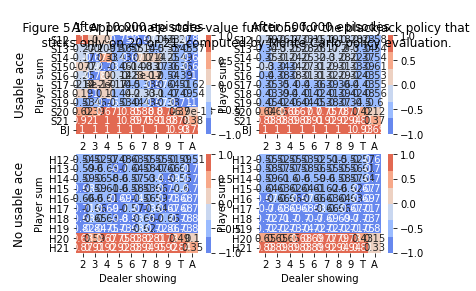

In [4]:
options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r].reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [5]:
pd.DataFrame(
    Vs[1].reshape(env.observation_shape),
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.5021,-0.4395,-0.4372,-0.4685,-0.4787,-0.4140,-0.3964,-0.4318,-0.5543,-0.6826
H5,-0.4766,-0.5323,-0.4977,-0.4700,-0.5386,-0.4177,-0.4493,-0.5033,-0.5451,-0.6345
H6,-0.4931,-0.4915,-0.5226,-0.4971,-0.4850,-0.4494,-0.5083,-0.4802,-0.5721,-0.6438
H7,-0.5307,-0.5143,-0.4856,-0.5035,-0.5360,-0.5338,-0.4989,-0.5198,-0.5551,-0.6656
H8,-0.5542,-0.5484,-0.5750,-0.5623,-0.5840,-0.5024,-0.4979,-0.5111,-0.5927,-0.6914
H9,-0.5013,-0.5340,-0.5120,-0.5417,-0.4915,-0.4943,-0.5097,-0.5066,-0.5679,-0.7359
H10,-0.1126,-0.1164,-0.1129,-0.1242,-0.0967,-0.0567,-0.0798,-0.0688,-0.2200,-0.3703
H11,-0.0833,-0.0583,-0.0018,-0.0684,-0.1035,-0.0765,-0.0469,-0.0280,-0.1361,-0.3550
H12,-0.5484,-0.5199,-0.5494,-0.5274,-0.5207,-0.5085,-0.5030,-0.5214,-0.5693,-0.6806
H13,-0.5816,-0.5748,-0.5656,-0.5829,-0.5613,-0.5498,-0.5469,-0.5642,-0.6055,-0.7103


## 5.3 Monte Carlo Control

**Example 5.3: Solving Blackjack**

In [6]:
episodes = 500_000
policy, Q, N = mc.Q_control_es(env, episodes, policy0=stand_on_20)
assert (policy == Q.argmax(axis=-1)).all()
policy = Q.argmax(axis=-1)
V = Q.max(axis=-1)

100%|██████████| 500000/500000 [00:11<00:00, 43118.75it/s]


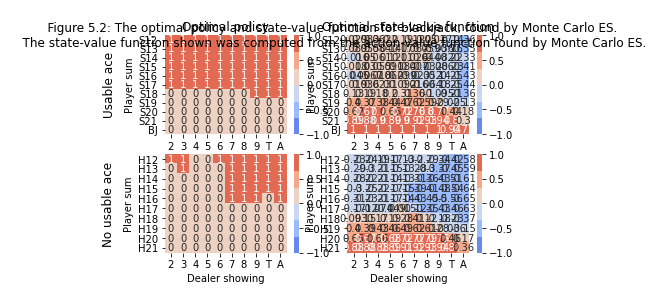

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy.reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V.reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [8]:
pd.DataFrame(
    V.reshape(env.observation_shape), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.0828,-0.1583,-0.0609,-0.0161,0.0255,-0.0252,-0.0991,-0.2386,-0.3357,-0.4983
H5,-0.1148,-0.1067,-0.1877,-0.0132,-0.0035,-0.1299,-0.1885,-0.2998,-0.3789,-0.4897
H6,-0.1499,-0.1217,-0.0522,-0.0663,-0.0000,-0.1900,-0.2286,-0.2500,-0.4054,-0.5234
H7,-0.1381,-0.0944,-0.0597,0.0115,0.0628,-0.0773,-0.2091,-0.2751,-0.4054,-0.5129
H8,-0.0285,0.0510,0.0095,0.0669,0.1105,0.0983,-0.0548,-0.2406,-0.2828,-0.4455
H9,0.0571,0.1013,0.1686,0.1542,0.2121,0.1829,0.0755,-0.0782,-0.1938,-0.3603
H10,0.1577,0.1939,0.2074,0.2580,0.2816,0.2102,0.1736,0.1191,-0.0504,-0.2812
H11,0.2047,0.2601,0.2535,0.3223,0.3445,0.2281,0.2075,0.1814,0.0831,-0.1974
H12,-0.2320,-0.2405,-0.1864,-0.1747,-0.1286,-0.1955,-0.2852,-0.3351,-0.4245,-0.5820
H13,-0.2912,-0.2968,-0.2050,-0.1529,-0.1343,-0.2790,-0.2997,-0.3708,-0.4534,-0.5943


In [9]:
pd.DataFrame(
    policy.reshape(env.observation_shape), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,H,H,H,H,H,H
H13,,H,,,,H,H,H,H,H


## 5.5 Off-policy Prediction via Importance Sampling

**Example 5.4: Off-policy Estimation of a Blackjack State Value**

In [10]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = np.ravel_multi_index(
    (bj.Hand.S13, bj.Card._2), 
    env.observation_shape
)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 100_000_000
V, _ = mc.V_predict_ev(env, target_policy, episodes, start=start)
V[start]

100%|██████████| 100000000/100000000 [44:07<00:00, 37774.24it/s]


-0.2773381299998859